In [18]:
import pandas as pd
import numpy as np
import IPython.display as ipd
from speechbrain.pretrained import EncoderClassifier
import os 
import librosa
import torch
import matplotlib.pyplot as plt


In [2]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech

processor = SpeechT5Processor.from_pretrained("/data3/abraham/tts/tts/src/experiments/wav2vec2-large-xlsr-53-discriminative-asr-accent-weighted-9-1/checkpoints")
model = SpeechT5ForTextToSpeech.from_pretrained("/data3/abraham/tts/tts/src/experiments/wav2vec2-large-xlsr-53-discriminative-asr-accent-weighted-9-1/checkpoints")

/home/ubuntu/anaconda3/envs/lora/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [8]:
device ="cuda:0"
def get_speaker_model(spk_model_name):

    speaker_model = EncoderClassifier.from_hparams(
        source=spk_model_name,
        run_opts={"device": device},
        savedir=os.path.join("/tmp", spk_model_name)
    )
    return speaker_model

def create_speaker_embedding( speech):
    speaker_model = get_speaker_model("speechbrain/spkrec-xvect-voxceleb")
    
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(speech).to(device))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().to("cpu").numpy()
    return speaker_embeddings

In [4]:
!dir /data3/data/AfriSpeech-TTS/dev/8b4472ce-d533-46b4-a90f-ffceb4657bd3/b742a15fb23dfdee788efa3f71523627_dVyNA9rN.wav

/data3/data/AfriSpeech-TTS/dev/8b4472ce-d533-46b4-a90f-ffceb4657bd3/b742a15fb23dfdee788efa3f71523627_dVyNA9rN.wav


In [10]:
path = "/data3/data/AfriSpeech-TTS/dev/8b4472ce-d533-46b4-a90f-ffceb4657bd3/b742a15fb23dfdee788efa3f71523627_dVyNA9rN.wav"
sample, sr = librosa.load(path, sr=16000)

In [11]:
speaker_embeddings= create_speaker_embedding(sample)
speaker_embeddings

/home/ubuntu/anaconda3/envs/lora/lib/python3.9/site-packages/torch/functional.py:641: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:862.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


array([-8.05826187e-02,  2.32399683e-02,  2.09245123e-02,  1.90608371e-02,
        2.69788746e-02, -1.81975737e-02, -4.03283387e-02,  1.02308607e-02,
        7.48275220e-02,  1.60885397e-02, -5.67662567e-02, -7.49742165e-02,
        8.08396637e-02,  5.18153841e-03,  3.79709043e-02,  6.43245056e-02,
       -6.09940942e-03,  4.62244377e-02,  7.71720801e-03, -1.33930929e-02,
        2.62542870e-02,  2.73554344e-02, -1.84068847e-02, -3.48600037e-02,
       -4.45367657e-02, -7.10230321e-03, -3.99077870e-02,  9.97301564e-03,
        2.41394341e-02,  1.08852154e-02, -2.14231573e-03,  5.63499145e-02,
        3.92483510e-02, -2.10859701e-02,  4.36886810e-02, -4.46874090e-02,
        6.46720305e-02,  6.89952150e-02, -5.95971302e-04, -7.74791986e-02,
        6.05248921e-02, -1.98245272e-02,  2.77219899e-02,  4.93538193e-02,
        1.59254372e-02, -1.13400944e-01, -2.16986630e-02,  1.20078875e-02,
       -6.87836930e-02,  3.50895487e-02,  2.63047982e-02,  4.91777025e-02,
        2.90118922e-02,  

In [12]:
speaker_embeddings = torch.tensor(speaker_embeddings).unsqueeze(0)
speaker_embeddings.shape

torch.Size([1, 512])

In [13]:
text = "I am going to the hospital today"

In [14]:
inputs = processor(text=text, return_tensors="pt")

In [15]:
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)

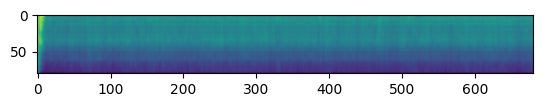

In [19]:
plt.figure()
plt.imshow(spectrogram.T)
plt.show()

In [21]:
from transformers import SpeechT5HifiGan
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

config.json: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 636/636 [00:00<00:00, 363kB/s]
pytorch_model.bin: 100%|████████████████████████████████████████████████████████████████████████████████| 50.7M/50.7M [00:00<00:00, 180MB/s]
/home/ubuntu/anaconda3/envs/lora/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [22]:
with torch.no_grad():
    speech = vocoder(spectrogram)

In [23]:
from IPython.display import Audio
Audio(speech.numpy(), rate=16000)